In [12]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


plt.style.use('../data/inputs/ploting.mplstyle')

# Load Data

In [13]:
data_path = "../data/results/MULTI-STATIONS -- 20251223_042417 -- ed4d/HAMILTON RBG CS - 6153301/02_copula_fitting/"
save_path = "../data/results/plots/"

df_ranks = pd.read_csv(data_path + "01_input_ranks.csv")
df_metrics = pd.read_csv(data_path + "02_copula_fit_metrics.csv")
df_cdf = pd.read_csv(data_path + "03_cdf_results.csv")
if 'Analytical' in df_cdf.columns:
    cols = ['Analytical'] + [c for c in df_cdf.columns if c != 'Analytical']
    df_cdf = df_cdf[cols]

df_return_periods = pd.read_csv(data_path + "04_return_periods.csv")
if 'Analytical' in df_return_periods.columns:
    cols = ['Analytical'] + [c for c in df_return_periods.columns if c != 'Analytical']
    df_return_periods = df_return_periods[cols]

print("Data loaded successfully.")
display(df_metrics)

Data loaded successfully.


,Family,param,df,LogLik,AIC,BIC,taildep.lower,taildep.upper,tau
0,Gaussian,0.826980,NaN,1038.384988,-2074.769975,-2069.189275,0.000000,0.00000,0.633955
1,t,0.826849,5.547089,1072.431212,-2140.862424,-2129.701024,0.458410,0.45841,0.643132
2,Clayton,3.622419,NaN,1263.871304,-2525.742608,-2520.161908,0.825844,0.00000,0.644281
3,Frank,9.049593,NaN,1035.968529,-2069.937057,-2064.356357,0.000000,0.00000,0.638277
4,Gumbel,2.342833,NaN,846.852720,-1691.705439,-1686.124740,0.000000,0.65572,0.573166


# 1. Input Data Ranks (Dependency Structure)

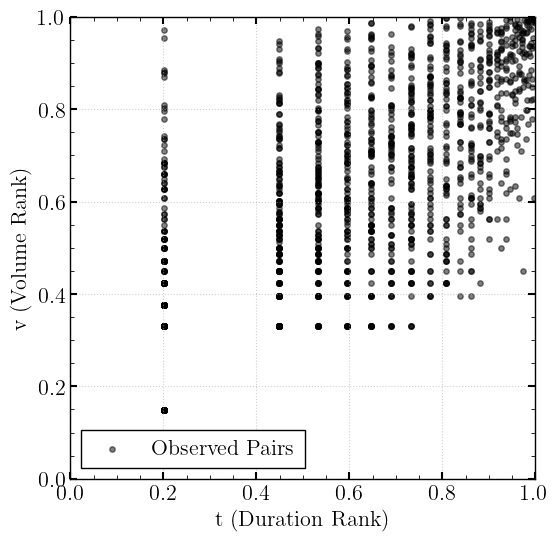

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(df_ranks['u_duration'], df_ranks['v_volume'], alpha=0.5, s=15, color='black', label='Observed Pairs')
plt.xlabel('t (Duration Rank)')
plt.ylabel('v (Volume Rank)')
# plt.title('Dependency Structure (Input Ranks)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig(save_path+"rank.pdf", bbox_inches='tight')
plt.show()

# 2. Copula Fit Metrics Comparison

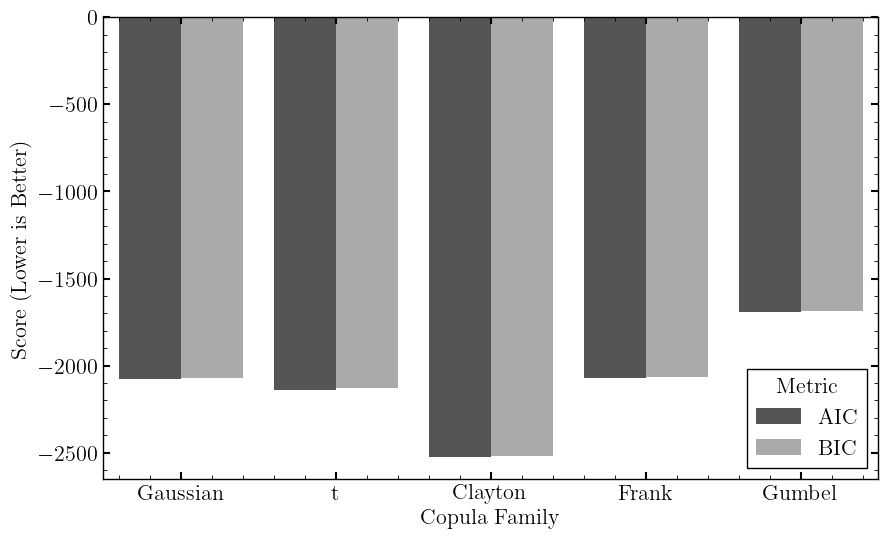

In [15]:
# Melt for seaborn plotting
metrics_melted = df_metrics.melt(id_vars=['Family'], value_vars=['AIC', 'BIC'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Family', y='Value', hue='Metric', palette="grey")
# plt.title('Goodness-of-Fit Metrics (AIC & BIC)')
plt.ylabel('Score (Lower is Better)')
plt.xlabel('Copula Family')
plt.legend(title='Metric')
# plt.savefig("plots/bootstrap_tau.pdf", bbox_inches='tight')
plt.show()

# 3. CDF Comparison

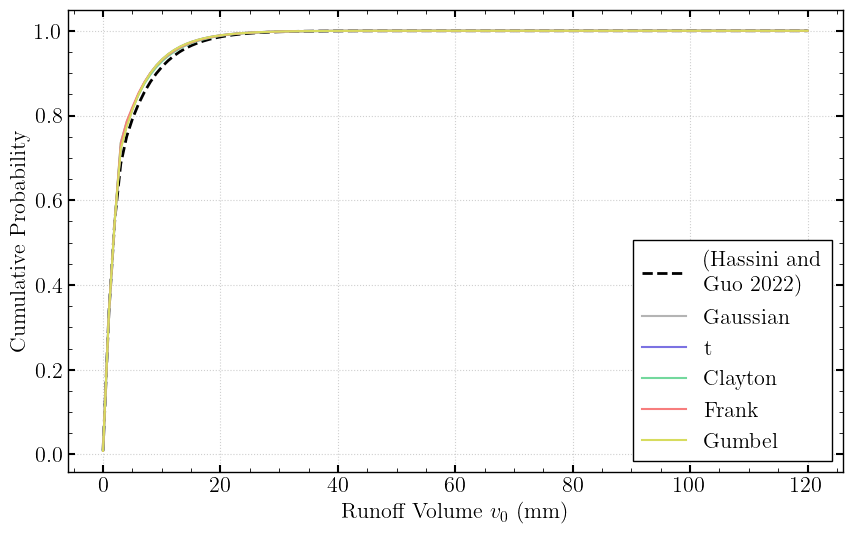

In [16]:
plt.figure(figsize=(10, 6))
for col in df_cdf.columns:
    if col != 'v0':
        # Highlight the 'Analytical' or best fit if known, otherwise just plot all
        lw = 2 if col == 'Analytical' else 1.5
        ls = '--' if col == 'Analytical' else '-'
        label =  "(Hassini and\n Guo 2022)" if col == "Analytical" else col
        plt.plot(df_cdf['v0'], df_cdf[col], label=label, linewidth=lw, linestyle=ls)

plt.xlabel(r'Runoff Volume $v_0$ (mm)')
plt.ylabel('Cumulative Probability')
# plt.title('CDF Comparison of Fitted Copulas')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig(save_path+"cdf.pdf", bbox_inches='tight')
plt.show()

# 4. Return Periods Analysis

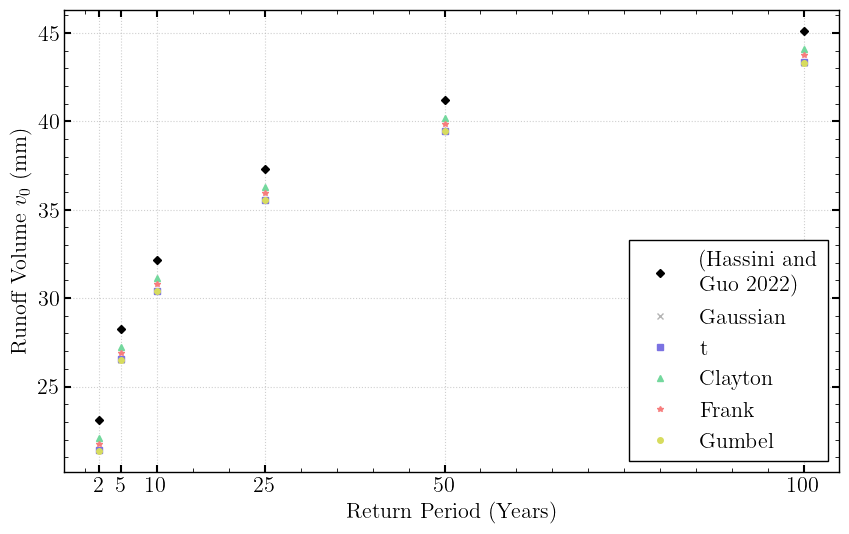

In [17]:
from matplotlib.ticker import MultipleLocator 

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_prop_cycle(color=["#000000", "#B4B4B4", "#7B72E2", "#73D89D", "#F77D7D", "#D7DC5E"], marker=['D', 'x', 's', '^', '*', 'o'])
for i, col in enumerate(df_return_periods.columns):
    if col != 'ReturnPeriod':
        label =  "(Hassini and\n Guo 2022)" if col == "Analytical" else col
        ax.plot(df_return_periods['ReturnPeriod'], df_return_periods[col], markersize=4, label=label, linestyle="")

plt.xlabel('Return Period (Years)')
plt.ylabel(r'Runoff Volume $v_0$ (mm)')
ax.set_xticks(df_return_periods['ReturnPeriod'])
ax.xaxis.set_minor_locator(MultipleLocator(5)) 
# plt.title('Return Period Analysis')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.savefig(save_path+"RT.pdf", bbox_inches='tight')
plt.show()